## Import a bunch of stuff we will be using:

In [1]:
#modules for transforming data and generating machine learning models
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.externals.six import StringIO

#visualization
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image
import pydotplus
from sklearn.tree import export_graphviz

## Load in data from the internet

In [2]:
cement_data = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/concrete/slump/slump_test.data",index_col=0)
#replace spaces and periods in column names with underscores
cement_data.columns = cement_data.columns.str.lower().str.replace(" ","_").str.replace(".","")

In [3]:
cement_data.head()

,cement,slag,fly_ash,water,sp,coarse_aggr,fine_aggr,slump(cm),flow(cm),compressive_strength_(28-day)(mpa)
No,,,,,,,,,,
1,273.0,82.0,105.0,210.0,9.0,904.0,680.0,23.0,62.0,34.99
2,163.0,149.0,191.0,180.0,12.0,843.0,746.0,0.0,20.0,41.14
3,162.0,148.0,191.0,179.0,16.0,840.0,743.0,1.0,20.0,41.81
4,162.0,148.0,190.0,179.0,19.0,838.0,741.0,3.0,21.5,42.08
5,154.0,112.0,144.0,220.0,10.0,923.0,658.0,20.0,64.0,26.82


We are going to motivate this exploration of individual decision trees by looking at a dataset from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Concrete+Slump+Test).

This dataset is a collection of measurements of compositional properties of concrete and their effect on the concrete's durability.

The dataset is composed of 7 input measurement features (kilograms per meter cubed of concrete):
  * Cement
  * Slag	
  * Fly ash	
  * Water	
  * SP	
  * Coarse Aggr.	
  * Fine Aggr.
  
And 3 output measurements:
  * SLUMP (cm)	
  * FLOW (cm)	
  * 28-day Compressive Strength (Mpa)

In [4]:
feature_names_cem = cement_data.columns.tolist()[:-3]
target_name = cement_data.columns.tolist()[-1]
cement_data["compressive_strength_bins"] = pd.cut(cement_data[target_name],5) #create 5 equally-sized bins

## Let's take a look at what we're working with:

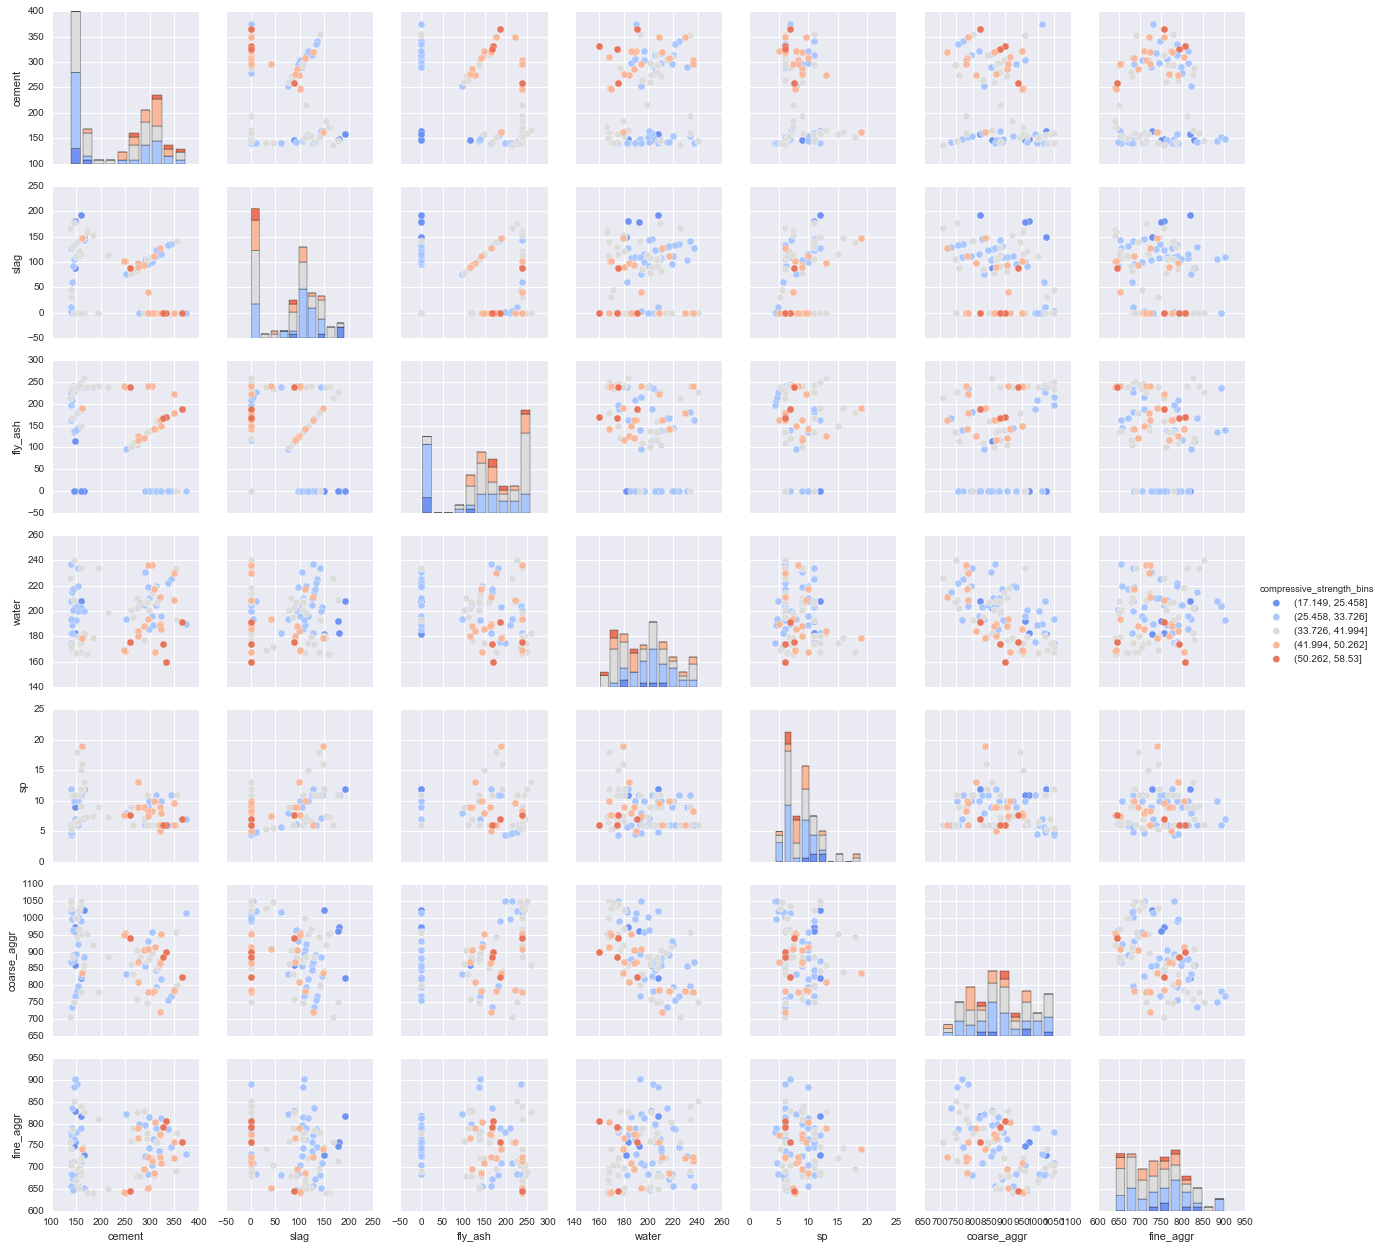

In [5]:
sns.pairplot(cement_data[feature_names_cem+['compressive_strength_bins']],
             hue="compressive_strength_bins",
             plot_kws=dict(s=50),palette='coolwarm')

## Lets look at one of the plots more closely:

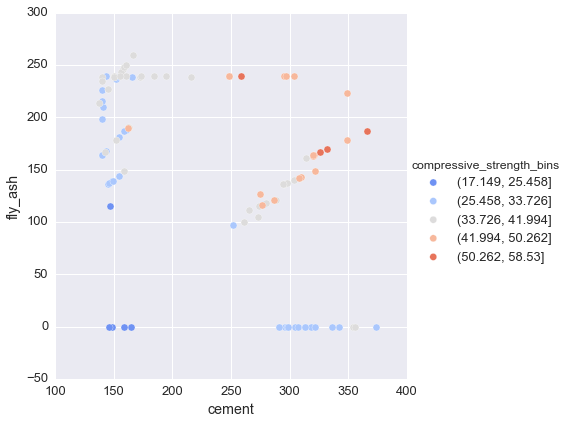

In [38]:
sns.pairplot(cement_data, x_vars=['cement'], y_vars=["fly_ash"],hue='compressive_strength_bins',size=6,plot_kws=dict(s=50),palette="coolwarm")

## Lets try to generate a decision tree model that takes the 6 input columns and attempts to predict compressive strength.

![O-C decision tree](../images/obama_hillary_decision_tree.jpg)

## Before we build our model, lets generate train/test splits of our data (60% training/40% testing):

In [7]:
X,y = cement_data[feature_names_cem],cement_data[target_name]
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.4,random_state=20)

## Now lets build our model and check its test error (using **RMSE**).

## *MSE or Mean Squared Error*, is the square of the difference between the predicted and the true value across all values in the dataset youre evaluating. 

## MSE is a popular model evaluation metric, because MSE "punishes" larger errors, which tends to be useful in the real world.

##  *RMSE, or Root Mean Squared Error*,  is even more popular than MSE, because RMSE is interpretable in the "y" units (in our case, how far off, on average we were in terms of compressive strength units).

## Both of these are what are called **loss functions**, because we want to minimize the **loss** (i.e. minimize how much we get stuff wrong)

## Heres the RMSE equation for the math nerds: 
## $$\sqrt{\frac 1n\sum_{i=1}^n(y_i-\hat{y}_i)^2}$$

In [8]:
decision_tree = DecisionTreeRegressor(max_depth=2)
decision_tree.fit(X_train,y_train)
print "Decision Tree RMSE:",np.sqrt(mean_squared_error(y_test,decision_tree.predict(X_test)))

Decision Tree RMSE: 5.32229449641


## Lets visualize our decision tree to understand how it's making a decision:

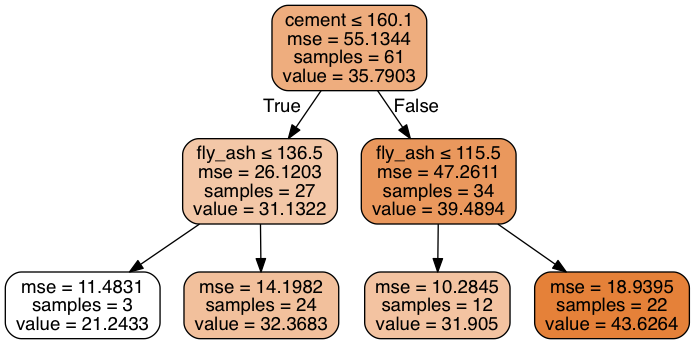

In [9]:
#This allows us to make a decision tree real fast directly in the notebook!
dot_data = StringIO()  
export_graphviz(decision_tree, out_file=dot_data,  
                    feature_names=X_train.columns.tolist(),  
                    filled=True, rounded=True,  
                    special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())  

## Heres how you would read the decision tree:

### - $R_1$: concrete with **less than or equal to 160.1 $kg/m^3$ of cement and fly ash less than or equal to 136.5 $kg/m^3$**, is predicted to have a mean compressive_strength of **21.24**
### - $R_2$: concrete with **less than or equal to 160.1 $kg/m^3$ of cement and fly ash more than 136.5 $kg/m^3$**, is predicted to have a mean compressive_strength of **32.37**
### - $R_3$: concrete with **more than 160.1 $kg/m^3$ of cement and fly ash less than or equal to 115.5 $kg/m^3$**, is predicted to have a mean compressive_strength of **31.91**
### - $R_4$: concrete with **more than 160.1 $kg/m^3$ of cement and fly ash more than 115.5 $kg/m^3$**, is predicted to have a mean compressive_strength of **43.63**

### These regions are used to make predictions on **out-of-sample data**. Thus, there are only 4 possible predictions!

In [10]:
np.unique(decision_tree.predict(X_test))

array([ 21.24333333,  31.905     ,  32.36833333,  43.62636364])

## Can we do better than this?


## OF COURSE WE CAN.

## ANY IDEAS HOW?

# BUILD A BUNCH OF DECISION TREES ON RANDOM SUBSETS OF THE DATA AND TAKE THEIR AVERAGE PREDICTION


# THIS IS CALLED BAGGING (BOOTSTRAP AGGREGATING). LETS DO THAT WITH 10 TREES AT FIRST

In [51]:
# set a seed for reproducibility
np.random.seed(1234)

# create ten bootstrap samples (will be used to select rows from the DataFrame)
samples = [np.random.choice(a=X_train.shape[0], size=X_train.shape[0], replace=True) for _ in range(1, 11)]
samples

[array([47, 19, 38, 53, 12, 52, 24, 57, 15, 49, 23, 41, 26, 30, 43, 30, 44,
        60, 26, 54, 58, 56, 48, 28,  5, 16,  9, 54, 47, 50, 48, 59, 12, 37,
        34, 38, 58,  3, 39, 11,  0, 41, 11, 16,  3,  2, 19, 12,  1, 11, 51,
        43, 58, 17, 14, 51,  7, 60, 42, 43, 46]),
 array([28, 17, 23, 13, 52, 32, 12,  5, 49, 31, 37, 31, 57, 60, 25, 20, 45,
        16, 41,  8, 56, 44,  6, 56, 22, 44, 26, 19, 47, 49, 18, 21, 46, 34,
        37, 45, 38,  7, 36,  3,  5, 46, 47, 54, 52, 54, 47, 15, 34, 10, 28,
         4, 18, 39, 25, 55, 43, 14, 23, 50, 57]),
 array([55, 20, 41,  0, 57, 34, 57, 26, 33, 50, 57, 49, 21,  7,  4, 55, 39,
        17, 58, 52,  0, 21, 52, 41, 50, 41,  1, 14,  3, 30, 12, 53,  9, 45,
        19, 26, 32,  4, 59, 36,  0, 22, 56, 20,  8, 44, 49, 24, 30, 41, 15,
         8,  2, 16, 43,  2, 50, 15,  3, 46, 34]),
 array([57, 55, 36, 24, 33, 57, 42,  2, 23, 45, 20, 35, 18, 12,  5, 53, 17,
        16,  8, 45, 11, 15, 20, 16,  0, 49, 32, 19, 57, 49, 57, 19, 27, 23,
        41, 35

In [52]:
# grow each tree deep
treereg = DecisionTreeRegressor(max_depth=None, random_state=123)

# list for storing predicted compressive strength from each tree
predictions = []

# define testing data
X_test_boot = X_test
y_test_boot = y_test

# grow one tree for each bootstrap sample and make predictions on testing data
for sample in samples:
    X_train_boot = X_train.iloc[sample, :]
    y_train_boot = y_train.iloc[sample]
    treereg.fit(X_train_boot, y_train_boot)
    y_pred_boot = treereg.predict(X_test_boot)
    predictions.append(y_pred_boot)

# convert predictions from list to NumPy array
predictions = np.array(predictions)
predictions

array([[ 36.46,  42.08,  52.65,  35.66,  42.08,  42.08,  35.52,  50.23,
         41.14,  38.46,  36.19,  42.08,  30.83,  36.59,  41.14,  41.27,
         45.82,  28.29,  36.19,  38.46,  42.08,  52.65,  33.91,  42.08,
         29.77,  42.08,  45.82,  42.08,  42.08,  38.46,  42.08,  29.77,
         36.19,  28.29,  31.77,  37.92,  27.62,  36.59,  28.7 ,  41.27,
         34.05,  45.82],
       [ 36.46,  36.46,  38.46,  28.7 ,  42.08,  44.08,  30.97,  41.01,
         41.81,  28.29,  32.57,  44.08,  28.29,  36.59,  41.01,  37.39,
         45.82,  33.51,  32.57,  42.08,  38.46,  46.36,  28.16,  41.01,
         36.46,  49.17,  45.82,  38.46,  42.08,  41.01,  38.46,  28.29,
         33.78,  36.46,  28.29,  37.92,  37.39,  28.29,  28.29,  41.01,
         33.51,  45.82],
       [ 35.52,  36.46,  52.65,  27.89,  42.08,  28.29,  28.29,  41.54,
         41.01,  28.29,  28.29,  27.62,  26.28,  26.28,  41.01,  35.52,
         46.36,  19.19,  28.29,  42.08,  49.17,  52.65,  31.9 ,  42.08,
         32.44

In [53]:
# calculate RMSE for bagged regression trees
y_pred_boot = np.mean(predictions, axis=0)
print "Bagged RMSE:",np.sqrt(mean_squared_error(y_test_boot, y_pred_boot))

#calculate RMSE for single decision tree with same exact parameters as each tree in the bag
single_tree = DecisionTreeRegressor(max_depth=None, random_state=123)
single_tree.fit(X_train,y_train)
y_pred_single = single_tree.predict(X_test)
print "Single Tree RMSE:",np.sqrt(mean_squared_error(y_test_boot, y_pred_single))

Bagged RMSE: 3.79270469203
Single Tree RMSE: 5.03474073669


## or you can do the same thing in way fewer lines:

In [54]:
bagreg = BaggingRegressor(DecisionTreeRegressor(), n_estimators=500, bootstrap=True, oob_score=True, random_state=1234)
# fit and predict
bagreg.fit(X_train, y_train)
y_pred_bag = bagreg.predict(X_test)

print "Bagged RMSE with 500 trees:",np.sqrt(mean_squared_error(y_test, y_pred_bag))

Bagged RMSE with 500 trees: 3.78785968654
